# Extracting and Classifying Face Images

https://dev.to/azure/opencv-detect-and-blur-faces-using-dnn-40ab

https://towardsdatascience.com/face-detection-models-which-to-use-and-why-d263e82c302c


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, get_scorer_names, precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import seaborn as sns

# We import the data set from tensorflow and build the model there
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.utils import np_utils
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3
import shutil
from PIL import Image
from PIL import ImageFile

import torch
# If you do not have a GPU or do not want to run this code on your GPU, comment out the following lines
torch.cuda.empty_cache()
torch.cuda.is_available()

True

## Extracting the Data

The images stored in the combined dataset are extracted into separate train and test set paths.

NOTE: Before running this file, please unzip the Distacted Driver Dataset that contains the combined dataset.

In [25]:
PARENT_PATH = os.getcwd()
DATA_PATH = os.path.join(os.getcwd(), "../Data/Combined New")
TEST_PATH = os.path.join(DATA_PATH, "test")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
UNSEEN_PATH = os.path.join(DATA_PATH, "unseen")
NUM_CLASSES = 8
TRAIN_PATH

'c:\\Users\\wamik\\Documents\\Notes Y4S2\\CS3244\\Projects\\Project 2\\CS3244-Group-8-Project-2\\Combined New\\train'

In [26]:
CLASS = [["c0", "Safe Driving"], ["c1", "Text"], ["c2", "Phone"], 
         ["c3", "Adjusting Radio"], ["c4", "Drinking"], 
         ["c5", "Reaching Behind"], ["c6", "Hair or Makeup"], 
         ["c7", "Talking to Passenger"]]
TEST_CLS = [os.path.join(os.getcwd(), TEST_PATH, cls[0]) for cls in CLASS]
TRAIN_CLS = [os.path.join(os.getcwd(), TRAIN_PATH, cls[0]) for cls in CLASS]
for cls_path in TEST_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))
for cls_path in TRAIN_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))

c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c0
711
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c1
667
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c2
602
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c3
264
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c4
255
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c5
243
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c6
242
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\test\c7
430
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Combined New\trai

For each class, the path of the training and test data is stored in separate lists. The corresponding labels are also stored in a different list

In [27]:
train_paths = []
test_paths = []
for cls in range(NUM_CLASSES):
  for train_instance in os.listdir(TRAIN_CLS[cls]):
    train_paths.append(os.path.join(TRAIN_CLS[cls], train_instance))
  for test_instance in os.listdir(TEST_CLS[cls]):
    test_paths.append(os.path.join(TEST_CLS[cls], test_instance))

In [28]:
classes = []
test_classes = []
for cls in range(NUM_CLASSES):
  for train_instance in os.listdir(TRAIN_CLS[cls]):
    classes.append(cls)
  for test_instance in os.listdir(TEST_CLS[cls]):
    test_classes.append(cls)

Then separate dataframes storing the train and test paths with their corresponding labels are created.

In [29]:
df = pd.DataFrame({
  'filename': train_paths,
  'class': classes
})
df

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
10220,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
10221,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
10222,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
10223,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


In [30]:
df_test = pd.DataFrame({
  'filename': test_paths,
  'class': test_classes
})
df_test

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
3409,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
3410,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
3411,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
3412,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


In [31]:
# -----------------------------------------------
# Face Detection using DNN Net
# -----------------------------------------------
# detect faces using a DNN model 
# download model and prototxt from https://github.com/spmallick/learnopencv/tree/master/FaceDetectionComparison/models

def detectFaceOpenCVDnn(net, frame):
    
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    blob = cv2.dnn.blobFromImage(frame, 1.0, mean = [104, 117, 123])

    net.setInput(blob)
    detections = net.forward()
    conf_threshold = 0.1
    box = None
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            conf_threshold = confidence
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            box = [x1, y1, x2, y2]

    if box == None:
        return []
    # extract the face
    # face_boundary = frame[box[1]:box[3], box[0]:box[2]]

    return box

**NOTE: Before running the code below, please download and unzip the models folder in the same directory as this notebook. The models folder can be downloaded from here: https://github.com/spmallick/learnopencv/tree/master/FaceDetectionComparison/models**

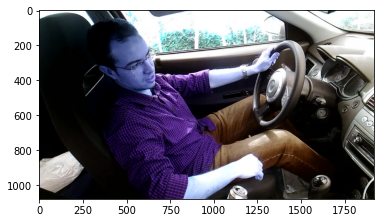

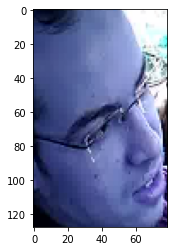

In [32]:
# load face detection model
modelFile = "../models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "../models/deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

img_orig = cv2.imread(df['filename'].iloc[10000])
plt.imshow(img_orig)
plt.show()
frame = cv2.resize(img_orig, (640, 480))

extracted_face = detectFaceOpenCVDnn(net, frame)
face_boundary = frame[extracted_face[1]:extracted_face[3], extracted_face[0]:extracted_face[2]]
plt.imshow(face_boundary)
plt.show()




In [44]:
PARENT_PATH = os.getcwd()
DATA_PATH = os.path.join(os.getcwd(), "../Data/Combined New")
TEST_PATH = os.path.join(DATA_PATH, "test")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
NEW_TRAIN_PATH = os.path.join(DATA_PATH, "new_train")
VALID_PATH = os.path.join(DATA_PATH, "valid")
UNSEEN_PATH = os.path.join(DATA_PATH, "unseen")
NUM_CLASSES = 8
CLS_LABELS = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
SAVE_PATH = os.path.join(os.getcwd(), '../Data/Combined new faces')

In [45]:
for class_folder in os.listdir(TRAIN_PATH):
  class_path = os.path.join(TRAIN_PATH, class_folder)
  if class_folder == ".DS_Store":
      continue
  train_imgs, test_imgs = train_test_split(os.listdir(class_path), test_size=0.2, random_state = 42)

  for img in train_imgs: 
    src = os.path.join(class_path, img)
    dst = os.path.join(NEW_TRAIN_PATH, class_folder, img)
    if not os.path.exists(os.path.join(NEW_TRAIN_PATH, class_folder)):
      os.makedirs(os.path.join(NEW_TRAIN_PATH, class_folder))
    shutil.copy(src, dst)

  for img in test_imgs: 
    src = os.path.join(class_path, img)
    dst = os.path.join(VALID_PATH, class_folder, img)
    if not os.path.exists(os.path.join(VALID_PATH, class_folder)):
      os.makedirs(os.path.join(VALID_PATH, class_folder))
    shutil.copy(src, dst)

In [46]:
datasets = [NEW_TRAIN_PATH, VALID_PATH, TEST_PATH, UNSEEN_PATH]
datasets_name = ['new_train', 'valid', 'test', 'unseen']

In [47]:
for dataset in datasets_name:
  for cls_label in CLS_LABELS:
    if not os.path.exists(os.path.join(SAVE_PATH, dataset, cls_label)):
       os.makedirs(os.path.join(SAVE_PATH, dataset, cls_label))

In [49]:
img_paths = []

for i in range(4):
  dataset = datasets[i]
  dataset_name = datasets_name[i]
  for cls_label in CLS_LABELS:
    cls_path = os.path.join(dataset, cls_label)
    for img in os.listdir(cls_path):
      if (img != '.DS_Store'):
        img_path = os.path.join(cls_path, img)
        img_orig = Image.open(img_path)
        img_re = img_orig.resize((640, 480))
        img_np = np.array(img_re)
        # Run object detection
        frame = detectFaceOpenCVDnn(net, img_np)
        width, height = img_re.size
        # Create a blank white image with the same dimensions as the original image
        # new_image = Image.new("RGB", (width, height), (255, 255, 255))
        box_pixels = img_re.crop((frame[0], frame[1], frame[2], frame[3]))
        pixels = np.array(box_pixels)
        pixels = cv2.cvtColor(pixels, cv2.COLOR_RGB2GRAY)
        final_img = Image.fromarray(pixels)
        save_path = os.path.join(SAVE_PATH, dataset_name, cls_label, img)
        if np.array(final_img).any():
          final_img.save(save_path)

## Transfer Learning with TensorFlow Keras

https://github.com/tejanirla/image_classification/blob/master/transfer_learning.ipynb

In [81]:
train_dir = "../Data/Combined new faces/new_train"
val_dir = "../Data/Combined new faces/valid"
test_dir = "../Data/Combined new faces/test"
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   width_shift_range = 0.02,
                                   height_shift_range = 0.02,
                                   horizontal_flip = False)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Note that the test data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 40 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 30,
                                                    class_mode = 'categorical', 
                                                    target_size = (100, 75), shuffle = True)   
# Flow validation images in batches of 40 using val_datagen generator
val_generator =  val_datagen.flow_from_directory( val_dir,
                                                          batch_size  = 30,
                                                          class_mode  = 'categorical', 
                                                          target_size = (100, 75), shuffle = True)  

# Flow validation images in batches of 40 using test_datagen generator
test_generator =  test_datagen.flow_from_directory( test_dir,
                                                          batch_size  = 30,
                                                          class_mode  = 'categorical', 
                                                          target_size = (100, 75), shuffle = False)

Found 7671 images belonging to 8 classes.
Found 1913 images belonging to 8 classes.
Found 3162 images belonging to 8 classes.


In [85]:
pre_trained_model = InceptionV3(input_shape = (100, 75, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = True

https://github.com/tejanirla/image_classification/blob/master/transfer_learning.ipynb

In [86]:
last_layer = pre_trained_model.get_layer('mixed4') #Only use layers including and above 'mixed4'
last_op = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_op)
# # Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(8, activation='softmax')(x)           

model = keras.Model(pre_trained_model.input, x) 

model.compile(optimizer = keras.optimizers.SGD(learning_rate=0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [87]:
from keras.callbacks import ModelCheckpoint


checkpoint = ModelCheckpoint(filepath='../models/best_model_face_inception.h5', 
                             monitor="val_acc",
                             verbose=1, 
                             save_best_only=True, 
                             mode="max")
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=10), checkpoint
]

history = model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 160,
            epochs = 200,
            validation_steps = 60,
            verbose = 2,
            callbacks=callbacks_list)

Epoch 1/200

Epoch 1: val_acc improved from -inf to 0.42611, saving model to best_model_face_inception.h5
160/160 - 23s - loss: 1.9681 - acc: 0.2819 - val_loss: 1.6443 - val_acc: 0.4261 - 23s/epoch - 142ms/step
Epoch 2/200

Epoch 2: val_acc improved from 0.42611 to 0.46889, saving model to best_model_face_inception.h5
160/160 - 20s - loss: 1.6469 - acc: 0.4101 - val_loss: 1.5304 - val_acc: 0.4689 - 20s/epoch - 124ms/step
Epoch 3/200

Epoch 3: val_acc improved from 0.46889 to 0.52889, saving model to best_model_face_inception.h5
160/160 - 20s - loss: 1.5302 - acc: 0.4525 - val_loss: 1.3885 - val_acc: 0.5289 - 20s/epoch - 125ms/step
Epoch 4/200

Epoch 4: val_acc improved from 0.52889 to 0.56833, saving model to best_model_face_inception.h5
160/160 - 20s - loss: 1.4081 - acc: 0.5080 - val_loss: 1.2928 - val_acc: 0.5683 - 20s/epoch - 125ms/step
Epoch 5/200

Epoch 5: val_acc improved from 0.56833 to 0.59389, saving model to best_model_face_inception.h5
160/160 - 20s - loss: 1.3271 - acc: 0.

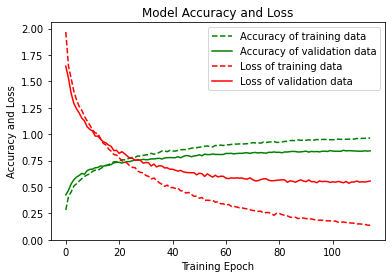

In [90]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [91]:
model = keras.models.load_model("../models/best_model_face_inception.h5")
score = model.evaluate(test_generator, verbose=1)
print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

106/106 [==============================] - 4s 31ms/step - loss: 0.4810 - acc: 0.8555

Accuracy on test data: 0.86

Loss on test data: 0.48


In [92]:
y_pred_test = model.predict(test_generator)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = test_generator.classes
precision = precision_score(max_y_test, max_y_pred_test, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(max_y_test, max_y_pred_test, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(max_y_test, max_y_pred_test, average='weighted')
print('F1 score: %f' % f1)

106/106 [==============================] - 4s 30ms/step
Precision: 0.855615
Recall: 0.855471
F1 score: 0.854926


In [93]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7]
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

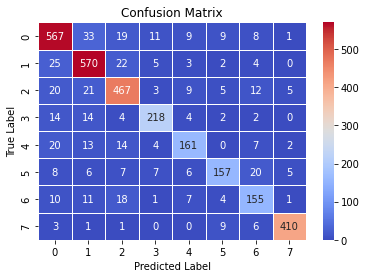


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       657
           1       0.85      0.90      0.88       631
           2       0.85      0.86      0.85       542
           3       0.88      0.84      0.86       258
           4       0.81      0.73      0.77       221
           5       0.84      0.73      0.78       216
           6       0.72      0.75      0.74       207
           7       0.97      0.95      0.96       430

    accuracy                           0.86      3162
   macro avg       0.84      0.83      0.84      3162
weighted avg       0.86      0.86      0.85      3162



In [94]:
show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

## Testing Results on Unseen Drivers

We will now evaluate model performance on a few drivers it hasn't seen before.

1/1 [==============================] - 0s 42ms/step


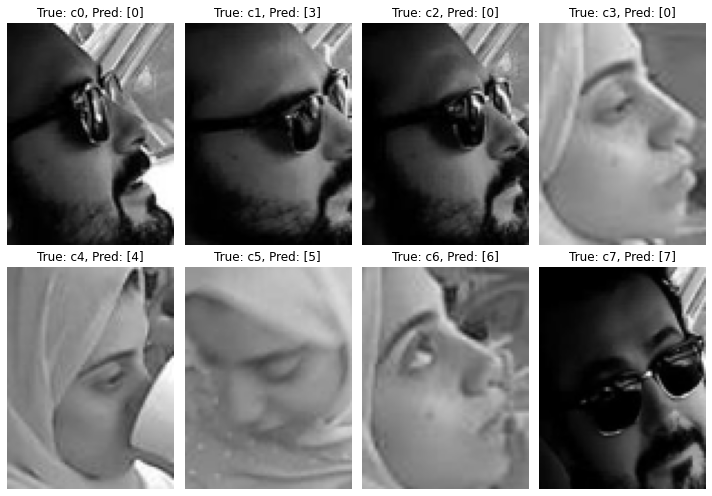

In [34]:
model = keras.models.load_model("../models/best_model_face_inception.h5")
UNSEEN_PATH = "../Data/Combined new faces/unseen"
imgs = []
y_preds = []
y_trues = []
img_number = [40, 32, 28, 40, 28, 45, 52, 34]
i = 0

for cls in os.listdir(UNSEEN_PATH):
    if cls != '.DS_Store':
        cls_path = os.path.join(UNSEEN_PATH, cls)
        img_name = os.listdir(cls_path)[img_number[i]]
        img_path = os.path.join(cls_path, img_name)
        img = Image.open(img_path).convert("RGB")
        img_resize = img.resize((75, 100))
        imgs.append(img_resize)
        img_array = np.asarray(img_resize)
        img_array = np.expand_dims(img_array, axis=0)
        input_data = img_array/255.0
        y_pred = model.predict(input_data)
        y_pred = np.argmax(y_pred, axis=1)
        y_preds.append(y_pred)
        y_trues.append(cls)
        i += 1

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
    # Plot the image
    img = imgs[i]
    ax.imshow(img)
    ax.axis('off')
    
    # Get the true and predicted labels
    true_label = y_trues[i]
    pred_label = y_preds[i]
    
    # Set the title of the plot with the true and predicted labels
    ax.set_title(f'True: {true_label}, Pred: {pred_label}')
    
    # Break out of the loop after 12 images have been plotted
    if i == 7:
        break

plt.tight_layout()
plt.show()